# Exercise 03 - Constrained optimization


We re-use the quadratic function from last exercise $f: \mathcal{R}^2 \rightarrow \mathcal{R}$ defined as 

$$
f(\mathbf{x}) = (\mathbf{x} - \tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x} - \tilde{\mathbf{x}})
$$
with 
$$
\mathbf{Q} = 
\begin{pmatrix}
    2 & 1 \\
    1 & 1 
\end{pmatrix} 
\quad 
\text{and}
\quad
\tilde{\mathbf{x}} = 
\begin{pmatrix}
    -1\\
    1 
\end{pmatrix}
$$
to test the implemented gradient decent methods.

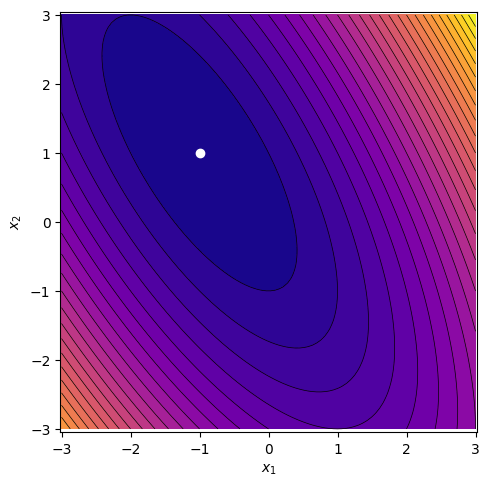

In [17]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem.utils import plot_contours

torch.set_default_dtype(torch.double)

# Define domain
x1 = torch.linspace(-3, 3, steps=100)
x2 = torch.linspace(-3, 3, steps=100)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)

# Define constants
xt = torch.tensor([-1.0, 1.0])
Q = torch.tensor([[2.0, 1.0], [1, 1.0]])


# Define function
def f(x):
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


# Plot function as contour lines
plot_contours(x, f(x), opti=[-1, 1], figsize=(5, 5))

## Task 1 - Box constraints
We want to solve the problem
$$
    \min_{\mathbf{x}} \quad f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})\\
    \textrm{s.t.} \quad      \mathbf{x}^- \le \mathbf{x} \le \mathbf{x}^+\\
$$


We have a predefined function named `box_constrained_decent(x_init, func, x_lower, x_upper, eta=0.1, maxiter=100)` that takes an initial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, a lower limit $\mathbf{x}^- \in \mathcal{R}^d$ named `x_lower`, an upper limit $\mathbf{x}^+ \in \mathcal{R}^d$ named `x_upper`,  a step size `eta`, and an iteration limit `max_iter`. 

a) Implement a simple steepest gradient decent in that function . The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [18]:
def box_constrained_decent(x_init, func, x_lower, x_upper, eta=0.1, max_iter=100):
    # Copy initial x to new differentiable tensor x
    x = x_init.clone().requires_grad_()

    points = [x]
    for _ in range(max_iter):
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Make a step
        x = x - eta * grad
        # Project
        x = torch.clamp(x, x_lower, x_upper)
        # Save intermediate results
        points.append(x)

    return points

b) Test the function with the following code for 
$$
    \mathbf{x}_0 = \begin{pmatrix}1\\-1\end{pmatrix}
    \quad 
    \mathbf{x}^{-} = \begin{pmatrix}0\\-2\end{pmatrix}
    \quad 
    \mathbf{x}^{+} = \begin{pmatrix}2\\2\end{pmatrix}
$$
and play around with the optional parameters. 

Final values are x_1=0.000, x_2=-0.000


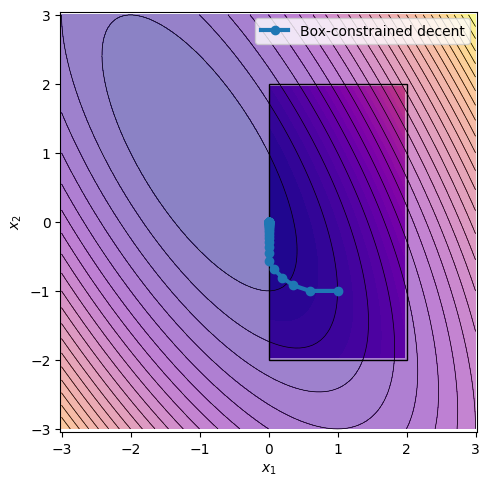

In [19]:
x_init = torch.tensor([1.0, -1.0])
x_lower = torch.tensor([0.0, -2.0])
x_upper = torch.tensor([2.0, 2.0])
path = box_constrained_decent(x_init, f, x_lower, x_upper)

plot_contours(
    x,
    f(x),
    box=[x_lower, x_upper],
    paths={"Box-constrained decent": path},
    figsize=(5, 5),
)
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")

## Task 2 - Visualizing Lagrangian duality

We consider a function $f: \mathcal{R} \rightarrow \mathcal{R}$ defined as 
$$ f(x) = x^2$$ 
for the box-constrained optimization problem 
$$
\min_{x} f(x) \\
s.t. \quad x \in [1, \infty).
$$
We can solve this problem easily by clamping the unconstrained solution $\hat{x}=0$ with the domain as 
$$ x^* = \textrm{clamp}(\hat{x}, 1, \infty) = 1$$
or using the algorithm from Task 1. 

a) Use the algorithm from Task 1 `box_constrained_decent` to solve this one-dimensional problem. 


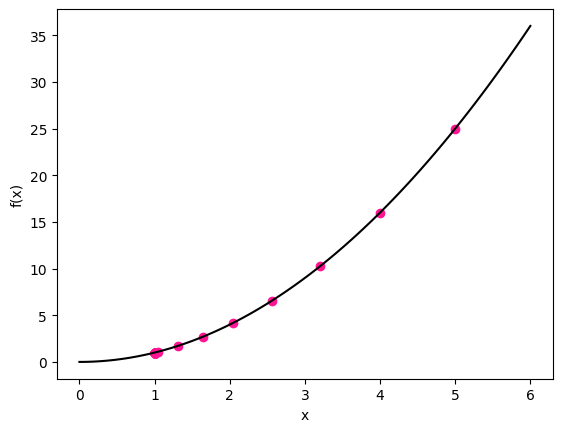

In [20]:
# Define 'x_init', 'x_lower' and 'x_upper'
x_init = torch.tensor([5.0])
x_lower = torch.tensor([1.0])
x_upper = None


# Define f(x)
def f(x):
    return x**2


# Solve the optimization
path = box_constrained_decent(x_init, f, x_lower, x_upper)


# Show the final result
x_test = torch.linspace(0, 6, 100)
with torch.no_grad():
    plt.plot(x_test, f(x_test), color="black")
    plt.scatter(path, f(torch.cat(path)), color="deeppink")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

However, we may also interpret the problem differently considering a function $g: \mathcal{R} \rightarrow \mathcal{R}$ defined as 
$$ g(x) = 1-x$$
for the constrained optimization problem 
$$
\min_{x} f(x) \\
s.t. \quad g(x) \le 0.
$$

b) Formulate the Lagrangian and plot the Langrangian as function of $x$ and $\mu$. Explain the shape of the plot.

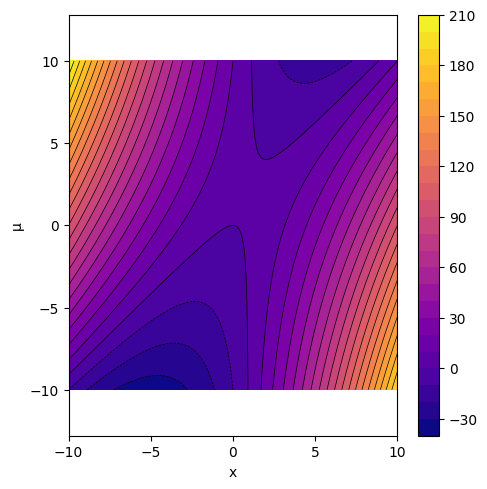

In [21]:
# Define domain
x_s = torch.linspace(-10, 10, steps=100)
mu_s = torch.linspace(-10, 10, steps=100)
x, mu = torch.meshgrid(x_s, mu_s, indexing="xy")


# Define Lagrangian
def L(x, mu):
    return x**2 + mu * (1 - x)


# Plot the Lagrangian
plot_contours(torch.stack([x, mu], dim=2), L(x, mu), colorbar=True, figsize=(5, 5))
plt.xlabel("x")
plt.ylabel("µ")
plt.show()

b) Solve the problem analytically using KKT conditions.

> The stationary point of the Lagrangian is 
> $$ \frac{\partial L}{\partial x} = 2 x^* - \mu^* = 0,$$
> $$ \frac{\partial L}{\partial \mu} = 1 - x^*  = 0.$$
> It follows that $x^*=1$ and $\mu^*=2$. The Lagrange parameter $\mu \neq 0$, therefore the constraint must be active $g(x^*)=0$.

c) Solve the problem using Lagrangian duality and visualize the dual problem in the plot by adding a line $x^*(\mu)$ and plotting the dual objective function. Interpret this line and how it is related to the dual procedure 
$$\max_{\mu} \min_{x} L(x, \mu)$$

> The stationary point of the Lagrangian w.r.t. $x$ is 
> $$ \frac{\partial L}{\partial x} = 2 x^* - \mu = 0,$$
> hence 
> $$ x^* = \frac{\mu}{2}$$
> and the dual objective function is 
> $$ \underline{L} = -\frac{1}{4}\mu^2 + \mu $$
> with the maximum located at $\mu=2$.
> Then, the optimum is $x^*=1$. 

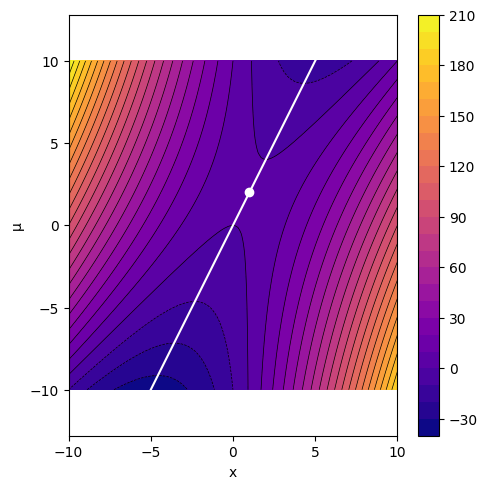

In [22]:
plot_contours(
    torch.stack([x, mu], dim=2),
    L(x, mu),
    opti=[1, 2],
    colorbar=True,
    figsize=(5, 5),
)
plt.plot(x_s, 2 * x_s, "-w")
plt.xlim([-10, 10])
plt.xlabel("x")
plt.ylim([-10, 10])
plt.ylabel("µ")
plt.show()

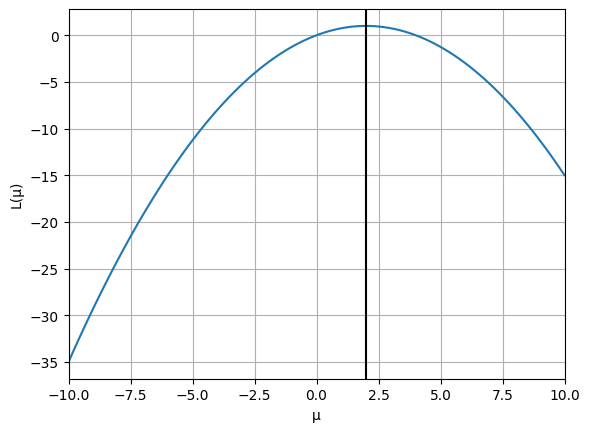

In [23]:
# The dual objective shows the values of the Lagrangian along the valley floor.
plt.plot(mu_s, -0.25 * mu_s**2 + mu_s)
plt.axvline(2.0, color="k")
plt.grid()
plt.xlim([-10, 10])
plt.xlabel("µ")
plt.ylabel("L(µ)")
plt.show()

## Task 3 - The first structural optimization problem

The three-bar truss illustrated below consists of three bars with the following properties:
- Bar 1 connecting nodes $n^0$ and $n^1$: cross section $A_1$, Young's modulus $E$, length $l$
- Bar 2 connecting nodes $n^1$ and $n^2$: cross section $A_2$, Young's modulus $E$, length $l$
- Bar 3 connecting nodes $n^0$ and $n^2$: cross section $A_3$, Young's modulus $E$, length $\sqrt{2}l$


The truss is subjected to a force $P>0$ at $\mathbf{n}^0$, fixed in $\mathbf{n}^1$ ($u^1_1=0, u^1_2=0$) and simply supported in $\mathbf{n}^2$ ($u^2_1=0$). We want to maximize the stiffness of the truss assembly by minimizing its compliance $P u_2^0$, where $u_2^0$ is the displacement in the vertical $x_2$-direction of node $n_0$. The volume of the trusses may not exceed a volume $V_0$. The design variables are the cross-sectional areas of the bars $\mathbf{a} = \begin{pmatrix} A_1,A_2,A_3\end{pmatrix}^\top$.


![Three bar truss](https://meyer-nils.github.io/structural_optimization/figures/three_bar_truss.png)


Credits: Peter W. Christensen and Anders Klarbring. *An Introduction to Structural Optimization.* Springer Netherlands, 2008.


a) Formulate the problem as a constrained optimization problem using an explicit expression for $u_2^0$.

> The constrained optimization problem is 
> $$
>   \min_{\mathbf{x}} f(\mathbf{a}) \\
>   s.t. \quad g(\mathbf{a}) = V(\mathbf{a}) - V_0 \le 0 \\
>        \quad \mathbf{a} \in \mathcal{R}^3_{>0}
> $$
> with the compliance 
> $$
> f(\mathbf{a}) = P u_2^0 (\mathbf{a})
> $$
> and 
> $$
> V(\mathbf{a}) = a_1l+a_2l+a_3 \sqrt{2}l.
> $$
> To obtain an expression for $u_2^0 (\mathbf{x})$, we nee to employ some mechanics:
> Free body diagrams provide us with forces in each truss 
> $$P_1 = -P$$
> $$P_2 = -P$$
> $$P_3 = \frac{2}{\sqrt{2}} P.$$
> Then we can evaluate static mechanics equations for each truss 
> $$P_1 = - E a_1 \frac{u_1^0}{l}$$
> $$P_2 = - E a_2 \frac{u_2^2}{l}$$
> $$P_3 = E a_3 \frac{u_2^0-u_1^0-u_2^2}{2l}$$
> and solve them for displacements: 
> $$u_2^2 = \frac{Pl}{E} \frac{1}{a_1}$$
> $$u_1^0 = \frac{Pl}{E} \frac{1}{a_2}$$
> $$u_2^0 = u_2^2 + u_1^0 + \frac{2\sqrt{2}Pl}{E} \frac{1}{a_3}$$
> Finally, we can express the compliance as 
> $$f(\mathbf{x}) = \frac{P^2l}{E} \left( \frac{1}{a_1} + \frac{1}{a_2} + \frac{2\sqrt{2}}{a_3} \right)$$
>
>
>

b) Solve the problem analytically using KKT conditions.

>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>

> The Lagrangian is 
> $$ L(a_1, a_2, a_3) = \frac{1}{a_1} + \frac{1}{a_2} + \frac{2\sqrt{2}}{a_3} + \mu \left(a_1l+a_2l+a_3\sqrt{2}l-V_0\right).$$
> The partial derivatives are 
> $$ \frac{\partial L}{\partial a_1} = - \frac{1}{(a_1^*)^2} + \mu^* l = 0$$
> $$ \frac{\partial L}{\partial a_2} = - \frac{1}{(a_2^*)^2} + \mu^* l = 0$$
> $$ \frac{\partial L}{\partial a_3} = - \frac{2\sqrt{2}}{(a_3^*)^2} + \mu^* \sqrt{2}l = 0$$
> $$ \frac{\partial L}{\partial \mu} = a_1^*l+a_2^*l+a_3^*\sqrt{2}l - V_0 = 0$$
> Obviously, $a_2^* = a_1^*$ and $\mu^*=\frac{1}{l (a_1^*)^2}$. Then, the third equations becomes
> $$ \sqrt{2} a_1^* = a_3^*.$$
> Inserting this to the last equation gives 
> $$ a_1^* = a_2^* = \frac{V_0}{4l} $$
> and finally 
> $$ a_3^* = \frac{\sqrt{2}V_0}{4l}.$$


c) Solve the problem analytically using Lagrangian duality.

> The problem is separable and the Lagrangian
> $$ L(a_1, a_2, a_3) = \frac{1}{a_1} + \frac{1}{a_2} + \frac{2\sqrt{2}}{a_3} + \mu \left(a_1l+a_2l+a_3\sqrt{2}l-V_0\right).$$
> may be expressed as 
> $$L(a_1, a_2, a_3) = L_1(a_1) + L_2(a_2) + L_3(a_3) $$
> with 
> $$ L_1(a_1) = \frac{1}{a_1} + \mu l a_1$$
> $$ L_2(a_2) = \frac{1}{a_2} + \mu l a_2$$
> $$ L_3(a_3) = \frac{2\sqrt{2}}{a_3} + \sqrt{2} \mu l a_3 - \mu V_0.$$
> The stationary points are 
> $$ \frac{ \partial L_1}{\partial a_1} = -\frac{1}{(a_1^*)^2} + \mu l = 0$$
> $$ \frac{ \partial L_2}{\partial a_2} = -\frac{1}{(a_2^*)^2} + \mu l = 0$$
> $$ \frac{ \partial L_3}{\partial a_3} = -\frac{2\sqrt{2}}{(a_3^*)^2} + \sqrt{2} \mu l = 0$$
> resulting in the expressions
> $$ a_1^* = a_2^* = \frac{1}{\sqrt{\mu l}}$$
> $$ a_3^* = \frac{\sqrt{2}}{\sqrt{\mu l}}.$$
> These are used to formulate the dual objective function 
> $$\underline{L}(\mu) = 8 \sqrt{\mu l} - \mu V_0.$$
> The maximum of this function is found by setting
> $$\frac{ \partial \underline{L}}{\partial \mu} = 4\frac{\sqrt{l}}{\sqrt{\mu^*}} - V_0 = 0, $$
> hence $\sqrt{\mu^* l}= \frac{4 l}{V_0}$, $a_1^* = a_2^* = \frac{V_0}{4l}$ and $a_3^* = \frac{\sqrt{2}V_0}{4l}$.

d) Define the objective function using $a_1=a_2$ and plot it in the $a_1$-$a_3$ plane as contour plot. Assuming $L=1$ and $V_0=1$, plot the contrained area.

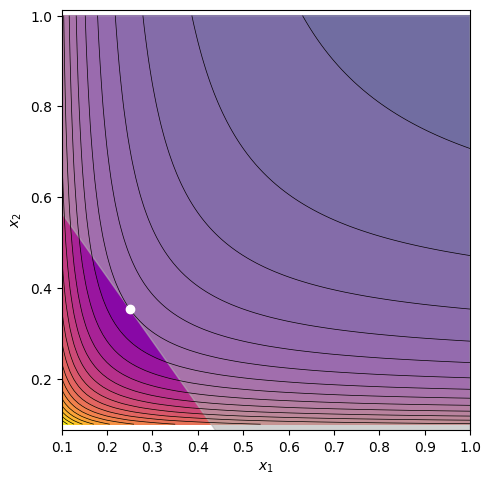

In [24]:
# Define domain
a1 = torch.linspace(0.1, 1.0, steps=100)
a3 = torch.linspace(0.1, 1.0, steps=100)
a = torch.stack(torch.meshgrid(a1, a3, indexing="xy"), dim=2)


def compliance(a):
    return 2.0 / a[..., 0] + 2.0 * sqrt(2.0) / a[..., 1]


def constraint(a1):
    V_0 = 1.0
    return 1.0 / sqrt(2.0) * (V_0 - 2.0 * a1)


plot_contours(a, compliance(a), opti=[0.25, sqrt(2.0) * 0.25], figsize=(5, 5))
plt.fill_between(a1, 1.0, constraint(a1), color=(0.7, 0.7, 0.7, 0.6))
plt.xlim([0.1, 1.0])
plt.ylim([0.1, 1.0])
plt.show()

>

>
